In [17]:
# Run on startup
# !pip install momepy
import momepy
import geopandas as gpd
import matplotlib.pyplot as plt
from pathlib import Path
import time
import networkx
import pandas as pd
from shapely.geometry import Polygon
from shapely.wkt import loads
import requests

In [38]:
dji_parcel_path = Path.cwd() / 'parcels_DJI.1.1_1.geojson'
dji_lines_path = Path.cwd() / 'lines_DJI.1.1_1.geojson'
dji_buildings_path = Path.cwd() / 'buildings_DJI.1.1_1.geojson'
dji_blocks_path = Path.cwd() / 'blocks_DJI.1.1_1.csv'

paths = {'Parcels': dji_parcel_path, 
         'Lines': dji_lines_path,
         'Buildings': dji_buildings_path}

dfs = {key: gpd.read_file(path).to_crs('EPSG:3395') for key, path in paths.items()}


dji_blocks_df = pd.read_csv(dji_blocks_path)
dji_blocks_df['geometry'] = dji_blocks_df['geometry'].apply(loads)
dji_blocks_gdf = gpd.GeoDataFrame(dji_blocks_df,
                                  crs='EPSG:3395',
                                  geometry='geometry')

dfs['Blocks'] = dji_blocks_df

# def clean_df(df):
#   df = momepy.close_gaps(df, tolerance=0.25)
#   df = momepy.extend_lines(df, tolerance=0.25)
#   return df

# dfs = {key: clean_df(key, value) for key, value in dfs.items()}

# Import Issues

To get momepy to work on my machine, I had to download the github release of geopandas,
and edit a line in momepy_venv/lib/python3.9/site-packages/libpysal/weights/util.py
to get rid of the line that checks the geopandas version. One clear potential issue with 
using Momepy is that not that many people seem to use it, so lots of bugs like this one don't
get found. I'm still not sure what my issue is caused by, and it's possible that it's an issue due to something on my end, but it seemed like momepy wasn't playing nice with the geopandas version that the most recent momepy version said it was supposed to work with (geopandas release 0.8.1).

That said, it seems to work fine in this Google Colab, which leads me to believe it was an issue with my setup specifically. 


#Momepy testing

I'm using the DJI data available in prclz/data.

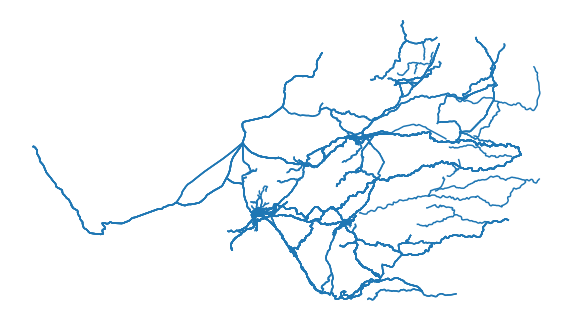

In [7]:
dfs['Lines'].plot(figsize=(10, 10)).set_axis_off()

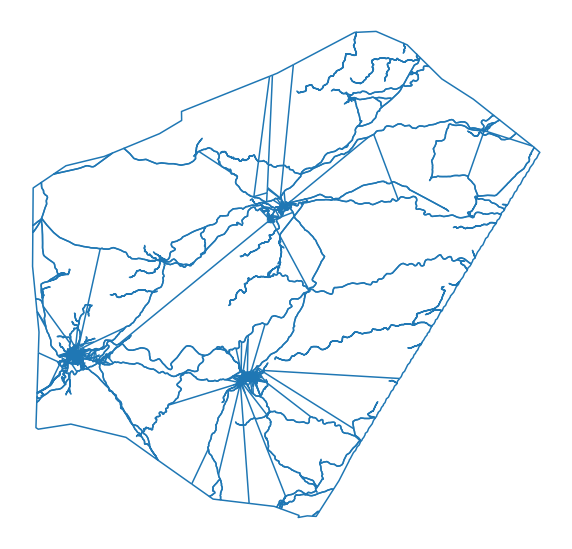

In [8]:
dfs['Parcels'].plot(figsize=(10, 10)).set_axis_off()

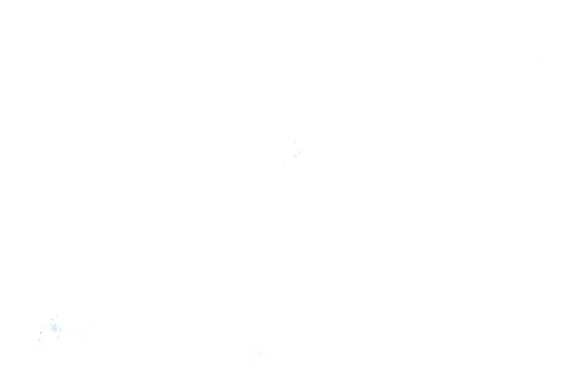

In [9]:
buildings = gpd.GeoSeries(dfs['Buildings']['geometry'])
buildings.plot(figsize=(10,10)).set_axis_off();
# This isn't blank, there's a few buildings but they're diffuse so 
# you can only see a few clusters

# Block Utilities

Momepy can do a bunch of quick calculations of measures I imagine would be important, like [block areas](http://docs.momepy.org/en/stable/generated/momepy.Area.html#momepy.Area), [perimeters](http://docs.momepy.org/en/stable/generated/momepy.Perimeter.html#momepy.Perimeter), [courtyard areas](http://docs.momepy.org/en/stable/generated/momepy.CourtyardArea.html#momepy.CourtyardArea), [fractal dimensions](http://docs.momepy.org/en/stable/generated/momepy.FractalDimension.html#momepy.FractalDimension), [rectangularity](http://docs.momepy.org/en/stable/generated/momepy.Rectangularity.html#momepy.Rectangularity), and [compactness](http://docs.momepy.org/en/stable/generated/momepy.SquareCompactness.html#momepy.SquareCompactness). Below I calculate each of these, time the calculations, and give a summary dataframe of the results.

In [12]:
measurements = ['Area', 'Perimeter', 'Courtyard Area', 'Fractal Dimension', 'Rectangularity', 'Square Compactness',
                'Elongation', 'Squareness']
measurements = {measure: ''.join(measure.split()) for measure in measurements}

for col_name, api_name in measurements.items():
    exec_code = f'momepy.{api_name}(dfs["Buildings"]).series'
    start = time.perf_counter()
    dfs['Buildings'][col_name] = eval(exec_code)
    end = time.perf_counter()
    print(f'{col_name} took {end - start:0.4f} seconds')

Area took 0.0075 seconds
Perimeter took 0.0026 seconds
Courtyard Area took 0.0462 seconds
Fractal Dimension took 0.0083 seconds
Rectangularity took 1.8721 seconds
Square Compactness took 0.0079 seconds


  7%|▋         | 285/3855 [00:00<00:01, 2832.04it/s]

Elongation took 1.8058 seconds


100%|██████████| 3855/3855 [00:01<00:00, 2690.78it/s]

Squareness took 1.4373 seconds


In [13]:
dfs['Buildings'].head()


,building,name,osm_id,osm_way_id,other_tags,gadm_code,geometry,Area,Perimeter,Courtyard Area,Fractal Dimension,Rectangularity,Square Compactness,Elongation,Squareness
0,house,None,9681417,None,"""type""=>""multipolygon""",DJI.1.1_1,"MULTIPOLYGON (((4778164.611 1259826.728, 47781...",334.908151,129.463051,NaN,1.196143,0.741065,0.319708,0.939490,NaN
1,yes,None,235993686,None,None,DJI.1.1_1,"POLYGON ((4802620.401 1268192.877, 4802624.019...",226.207526,69.020046,0.0,1.050679,0.998177,0.759760,0.341709,0.267714
2,yes,None,235993688,None,None,DJI.1.1_1,"POLYGON ((4802249.195 1267795.991, 4802260.605...",143.411617,47.957832,0.0,1.000471,1.000000,0.997666,0.907833,0.000000
3,yes,None,235993690,None,None,DJI.1.1_1,"POLYGON ((4802640.093 1268228.451, 4802649.845...",145.753218,48.608716,0.0,1.002630,0.995792,0.986983,0.792310,0.297883
4,yes,None,235993691,None,None,DJI.1.1_1,"POLYGON ((4802404.953 1268054.451, 4802409.662...",67.857476,36.141510,0.0,1.043839,0.996714,0.831199,0.416989,0.347436


In [14]:
buildings = dfs['Buildings']
buildings = buildings[buildings['geometry'].apply(lambda x: isinstance(x, Polygon))]
print(all([b.is_valid for b in buildings['geometry']]))
print(all([b.exterior.is_valid for b in buildings['geometry']]))
buildings = buildings.iloc[2:3]
# buildings.geometry = [polygon_fixer(bad_poly) for bad_poly in buildings['geometry']]
# buildings.geometry = momepy.close_gaps(buildings, 20000)
# buildings.geometry = momepy.extend_lines(buildings, tolerance=0.25)

enclosed_tess = momepy.Tessellation(buildings, 
                                    unique_id='osm_id')

True


IllegalArgumentException: Points of LinearRing do not form a closed linestring


True


ValueError: ignored

geojson linter says that old-style crs member is not recommended, this object is equivalent to the default and should be removed. Also it asks that we use the "right-hand rule", but it doesn't say any of the lines are invalid